<center>
<h4>Universidad Nacional de Córdoba - Facultad de Matemática, Astronomía, Física y Computación</h4>
<h3>Diplomatura en Ciencia de Datos, Aprendizaje Automático y sus Aplicaciones</h3>
<h2>Mentoría: Clasificación diagnóstica de mamografías </h2>
</center>

<h3>Práctico V - Clustering<h3>

<h4>Integrantes: Mario Agustín Sgró, Lucía Benítez y Carolina Díaz<h4>

**Objetivo y alcance:** 
    Explorar y falimiarizarce con técnicas de Clustering
    
**Método:** Técnicas de clustering, tabla de contingencia, medida inercia, silouette y medida de pureza para evaluación.(https://nlp.stanford.edu/IR-book/html/htmledition/evaluation-of-clustering-1.html)

**Estructura del informe:** 
Presentar en un archivo jupyter notebook con la resolución detallada de las siguientes consignas:

    1. Considerar la base sin la variable acr (target)
    2. Realizar una técnica de clustering (puede ser k-medias) con la base completa sin la variable target (acr), considerando k = 2, 3, 4, 5 y 6 clases, elegir dos cantidades que consideren más adecuada.
    3. Dividir a la base en 3 subconjuntos de variables (pueden ser DF, dcm, y otras), realizar las mismas técnicas de cluster a cada subconjunto.  
    4. Evaluar y comparar los resultados de los puntos 2 y 3 utilizando varios métodos incluídos la Tabla de contingencia y la cantidad de mamografías en cada clase o cluster encontrado, para ver la proporción de cada clase con respecto al resto, notando que tener una clase mayoritaria significativamente más grande que el resto es una clara evidencia de que no ha sido una buena división en clusters. Incluir también en la evaluación la medida de pureza (se usa para esto último algunos datos etiquetados con acr) se emulando con esta situación conocimiento de dominio.

In [71]:
import pandas as pd
from scipy import stats
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
import seaborn as sns
import string

from itertools import cycle, islice
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import kneighbors_graph
from sklearn import cluster, mixture
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn import metrics
import matplotlib.cm as cm

%pylab inline
plt.rcParams['figure.figsize'] = (10, 10)

Populating the interactive namespace from numpy and matplotlib


In [72]:
if sns.__version__ != '0.9.0':
    print('Atención! utilizamos seaborn versión 0.9.0')

In [73]:
pd.options.display.max_columns = 200
pd.options.display.max_rows = 1000

In [74]:
def purity_score(y_true, y_pred):
    # compute contingency matrix (also called confusion matrix)
    contingency_matrix = metrics.cluster.contingency_matrix(y_true, y_pred)
    # return purity
    return np.sum(np.amax(contingency_matrix, axis=0)) / np.sum(contingency_matrix) 

# Carga del DataSet

In [75]:
dataframe = pd.read_csv('datos/KnnFilled_data.csv',sep=',',index_col=['Imagen'])

## Descripción de la base de datos:

In [76]:
dataframe.head(3)

,Age,View,Laterality,Dcm_1,Dcm_2,Dcm_3,Dcm_4,Dcm_5,Dcm_6,Dcm_8,Dcm_9,Dcm_10,Dcm_11,Dcm_12,Dcm_13,Dcm_14,Dcm_17,Dcm_18,Dcm_19,Dcm_20,Dcm_21,Dcm_22,Dcm_23,Area,Promedio,Media,Desvio,Asimetria,Kurtosis,Moda,Desvio_L1,Desvio_L2,Desvio_L3,Asimetria_L1,Asimetria_L2,Asimetria_L3,promGradiente,Relacion,Relacion_L1,Relacion_L2,Relacion_L3,Relacion_L4,EP,EPBinaria,RelEntropia,Haralick_1,Haralick_2,Haralick_3,Haralick_4,Haralick_5,Haralick_6,Haralick_7,Haralick_8,Haralick_9,Haralick_10,Haralick_11,Haralick_12,Haralick_13,Haralick_14,Haralick_15,Haralick_16,Haralick_17,Haralick_18,Haralick_19,Haralick_20,Haralick_21,Haralick_22,Haralick_23,Haralick_24,Haralick_25,Haralick_26,Haralick_27,Haralick_28,Haralick_29,Haralick_30,Haralick_31,Haralick_32,Haralick_33,Haralick_34,Haralick_35,Haralick_36,Haralick_37,Haralick_38,Haralick_39,Haralick_40,Haralick_41,Haralick_42,Haralick_43,Haralick_44,Haralick_45,Haralick_46,Haralick_47,Haralick_48,Haralick_49,Haralick_50,Haralick_51,Haralick_52,DF1,DF2,DF3,DF4,DF5,DF6,DF7,DF8,DF9,DF10,DF11,DF12,DF13,DF14,DF15,DF16,DF17,DF18,DF19,DF20,DF21,DF22,DF23,DF24,DF25,DF26,DF27,DF28,DF29,DF30,DF31,DF32,DF33,DF34,DF35,DF36,DF37,DF38,DF39,DF40,DF41,DF42,DF43,DF44,DF45,DF46,DF47,DF48,DFb1,DFb2,DFb3,DFb4,DFb5,DFb6,DFb7,DFb8,DFb9,DFb10,DFb11,DFb12,DFb13,DFb14,DFb15,DFb16,DFb17,DFb18,DFb19,DFb20,DFb21,DFb22,DFb23,DFb24,DFb25,DFb26,DFb27,DFb28,DFb29,DFb30,DFb31,DFb32,DFb33,DFb34,DFb35,DFb36,DFb37,DFb38,DFb39,DFb40,DFb41,DFb42,DFb43,DFb44,DFb45,DFb46,DFb47,DFb48,ACR
Imagen,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Imagen_0.npy,47,CC,R,29,130,155,1115,RHODIUM,0.05,TUNGSTEN,54,58.5,700,621,1.073,-8.4,321,6.53,0.0172,0.531,2047,4096,NO,1906717.0,1204.432,1108.0,651.4016,0.631631,-0.158630,771,582.4619,617.4143,571.6266,1.254898,0.340503,0.478727,26.26389,50.87242,30.24690,39.02587,57.28405,56.46259,0.769471,0.176043,0.012500,0.000003,29632.09,0.965015,423492.9,0.010546,2407.881,1664340.0,12.23707,18.93313,8.625112e-07,8.446691,-0.209392,0.994013,0.000002,35926.62,0.957571,423372.4,0.009612,2407.639,1657563.0,12.23560,19.05275,7.760232e-07,8.586088,-0.198048,0.992383,0.000003,30038.18,0.964600,424267.4,0.010677,2408.827,1667031.0,12.23821,18.94111,8.581286e-07,8.455624,-0.208819,0.993943,0.000002,35106.38,0.958552,423500.1,0.009655,2407.789,1658894.0,12.23603,19.04234,7.841840e-07,8.570271,-0.199065,0.992547,1.304171,0.026670,226.2788,41.33949,-0.004142,-0.801469,1.739567,0.322655,571.4892,158.3410,-1.165407,-0.038599,1.770398,0.299554,1114.8870,161.6702,-1.183844,0.085194,1.720933,0.239347,1706.529,189.6891,-1.103810,0.225300,1.563104,0.110528,2449.700,306.2983,1.157895,1.152985,1.748927,0.349874,1941.302,416.6666,0.676891,0.995952,1.852387,0.649428,1560.111,524.6931,0.226560,0.823606,1.911039,0.972917,1231.635,639.3401,-0.129694,0.658866,1.347935,0.041248,303.0675,57.46704,2.316524,0.466817,1.704150,0.247506,768.1626,262.7135,-0.122940,-0.589775,1.798841,0.421929,1148.854,337.0629,-0.678163,0.150996,1.751035,0.341997,1627.667,380.1404,-0.268313,0.277035,1.569299,0.124358,2030.373,254.0663,8.731229,-1.076601,1.679952,0.224516,1405.837,235.7887,5.110653,-0.352031,1.663799,0.207258,867.1065,193.9527,14.221940,0.852135,1.362630,0.046754,334.1525,266.1445,42.72726,5.647393,c
Imagen_1.npy,47,MLO,R,28,100,115,1102,RHODIUM,0.05,TUNGSTEN,47,86.0,700,628,1.073,-44.9,301,4.33,0.0126,0.519,2047,4096,NO,1993379.0,1095.675,966.0,617.9254,0.822188,0.159056,771,577.9997,630.1512,590.6332,1.092861,0.499981,0.421337,26.20456,50.05200,35.61213,48.70387,58.67281,50.21066,0.771289,0.165031,0.053571,0.000003,40089.94,0.947479,381659.3,0.008924,2191.234,1486547.0,12.11379,18.84358,7.420714e-07,8.663215,-0.180066,0.987916,0.000003,48232.54,0.936822,381719.3,0.008153,2191.125,1478644.0,12.11180,18.95654,6.710952e-07,8.795995,-0.169177,0.984837,0.000003,39645.09,0.948079,381785.4,0.009185,2191.270,

In [77]:
print("El data set consiste de ",dataframe.shape[0]," imagenes, con ",dataframe.shape[1]," registros cada una.")

El data set consiste de  6605  imagenes, con  194  registros cada una.


## Tipos de Variables

In [78]:
CatFeat = [x for x in dataframe.columns if dataframe[x].dtype == 'object']
NumFeat = [x for x in dataframe.columns if dataframe[x].dtype == 'float64']
IntFeat = [x for x in dataframe.columns if dataframe[x].dtype == 'int64']

print('Cantidad' + str('\n')+
      '   variables numéricas   ' + str(len(NumFeat)) + str('\n') +
      '   variables enteras     ' + str(len(IntFeat)) + str('\n') +
      '   variables categóricas ' + str(len(CatFeat)))

Cantidad
   variables numéricas   176
   variables enteras     12
   variables categóricas 6


In [79]:
dataframe[CatFeat].describe(include='all')

,View,Laterality,Dcm_5,Dcm_8,Dcm_23,ACR
count,6605,6605,6605,6605,6605,6605
unique,3,2,4,2,2,4
top,MLO,R,RHODIUM,TUNGSTEN,NO,c
freq,3359,3314,4379,4987,5905,2898


In [80]:
dataframe[IntFeat].describe(include='all')

,Age,Dcm_1,Dcm_2,Dcm_3,Dcm_4,Dcm_9,Dcm_11,Dcm_12,Dcm_17,Dcm_21,Dcm_22,Moda
count,6605.000000,6605.000000,6605.000000,6605.000000,6605.000000,6605.000000,6605.000000,6605.000000,6605.000000,6605.000000,6605.000000,6605.000000
mean,54.553974,29.686298,116.203179,126.815443,1009.372748,58.985617,690.201363,621.394852,389.701136,2043.805753,4088.547464,745.178955
std,10.753220,1.761267,26.006182,54.368081,246.733822,14.171719,17.203982,16.466456,142.277302,69.312727,161.714364,292.887783
min,28.000000,24.000000,30.000000,31.000000,205.000000,15.000000,660.000000,561.000000,44.000000,540.000000,580.000000,1.000000
25%,46.000000,28.000000,100.000000,85.000000,817.000000,49.000000,700.000000,610.000000,347.000000,2047.000000,4096.000000,645.000000
50%,54.000000,30.000000,100.000000,120.000000,1115.000000,59.000000,700.000000,622.000000,387.000000,2047.000000,4096.000000,727.000000
75%,62.000000,31.000000,130.000000,155.000000,1168.000000,68.000000,700.000000,640.000000,462.000000,2047.000000,4096.000000,771.000000
max,91.000000,37.000000,200.000000,446.000000,2424.000000,114.000000,700.000000,660.000000,2780.000000,2047.000000,4096.000000,4093.000000


In [81]:
for feature in IntFeat:
  _u = dataframe[feature].unique()
  print(feature,len(_u))

Age 59
Dcm_1 14
Dcm_2 18
Dcm_3 310
Dcm_4 952
Dcm_9 96
Dcm_11 2
Dcm_12 96
Dcm_17 481
Dcm_21 2
Dcm_22 2
Moda 504


In [82]:
dataframe[NumFeat].describe(include='all')

,Dcm_6,Dcm_10,Dcm_13,Dcm_14,Dcm_18,Dcm_19,Dcm_20,Area,Promedio,Media,Desvio,Asimetria,Kurtosis,Desvio_L1,Desvio_L2,Desvio_L3,Asimetria_L1,Asimetria_L2,Asimetria_L3,promGradiente,Relacion,Relacion_L1,Relacion_L2,Relacion_L3,Relacion_L4,EP,EPBinaria,RelEntropia,Haralick_1,Haralick_2,Haralick_3,Haralick_4,Haralick_5,Haralick_6,Haralick_7,Haralick_8,Haralick_9,Haralick_10,Haralick_11,Haralick_12,Haralick_13,Haralick_14,Haralick_15,Haralick_16,Haralick_17,Haralick_18,Haralick_19,Haralick_20,Haralick_21,Haralick_22,Haralick_23,Haralick_24,Haralick_25,Haralick_26,Haralick_27,Haralick_28,Haralick_29,Haralick_30,Haralick_31,Haralick_32,Haralick_33,Haralick_34,Haralick_35,Haralick_36,Haralick_37,Haralick_38,Haralick_39,Haralick_40,Haralick_41,Haralick_42,Haralick_43,Haralick_44,Haralick_45,Haralick_46,Haralick_47,Haralick_48,Haralick_49,Haralick_50,Haralick_51,Haralick_52,DF1,DF2,DF3,DF4,DF5,DF6,DF7,DF8,DF9,DF10,DF11,DF12,DF13,DF14,DF15,DF16,DF17,DF18,DF19,DF20,DF21,DF22,DF23,DF24,DF25,DF26,DF27,DF28,DF29,DF30,DF31,DF32,DF33,DF34,DF35,DF36,DF37,DF38,DF39,DF40,DF41,DF42,DF43,DF44,DF45,DF46,DF47,DF48,DFb1,DFb2,DFb3,DFb4,DFb5,DFb6,DFb7,DFb8,DFb9,DFb10,DFb11,DFb12,DFb13,DFb14,DFb15,DFb16,DFb17,DFb18,DFb19,DFb20,DFb21,DFb22,DFb23,DFb24,DFb25,DFb26,DFb27,DFb28,DFb29,DFb30,DFb31,DFb32,DFb33,DFb34,DFb35,DFb36,DFb37,DFb38,DFb39,DFb40,DFb41,DFb42,DFb43,DFb44,DFb45,DFb46,DFb47,DFb48
count,6605.000000,6605.000000,6605.000000,6605.000000,6605.000000,6605.000000,6605.000000,6.605000e+03,6605.000000,6605.000000,6605.000000,6605.000000,6605.000000,6605.000000,6605.000000,6605.000000,6605.000000,6605.000000,6605.000000,6605.000000,6605.000000,6605.000000,6605.000000,6605.000000,6605.000000,6605.000000,6605.000000,6605.000000,6605.000000,6605.000000,6605.000000,6.605000e+03,6605.000000,6605.000000,6.605000e+03,6605.000000,6605.000000,6.605000e+03,6605.000000,6605.000000,6605.000000,6605.000000,6605.000000,6605.000000,6.605000e+03,6605.000000,6605.000000,6.605000e+03,6605.000000,6605.000000,6.605000e+03,6605.000000,6605.000000,6605.000000,6605.000000,6605.000000,6605.000000,6.605000e+03,6605.000000,6605.000000,6.605000e+03,6605.000000,6605.000000,6.605000e+03,6605.000000,6605.000000,6605.000000,6605.000000,6605.000000,6605.000000,6.605000e+03,6605.000000,6605.000000,6.605000e+03,6605.000000,6605.000000,6.605000e+03,6605.000000,6605.000000,6605.000000,6605.000000,6605.000000,6605.000000,6605.000000,6605.000000,6605.000000,6605.000000,6605.000000,6605.000000,6605.000000,6605.000000,6605.000000,6605.000000,6605.000000,6605.000000,6605.000000,6605.000000,6605.000000,6605.000000,6605.000000,6605.000000,6605.000000,6605.000000,6605.000000,6605.000000,6605.000000,6605.000000,6605.000000,6605.000000,6605.000000,6605.000000,6605.000000,6605.000000,6605.000000,6605.000000,6605.000000,6605.000000,6605.000000,6605.000000,6605.000000,6605.000000,6605.000000,6605.000000,6605.000000,6605.000000,6605.000000,6605.000000,6605.000000,6605.000000,6605.000000,6605.000000,6605.000000,6605.000000,6605.000000,6605.000000,6605.000000,6605.000000,6605.000000,6605.000000,6605.000000,6605.000000,6605.000000,6605.000000,6605.000000,6605.000000,6605.000000,6605.000000,6605.000000,6605.000000,6605.000000,6605.000000,6605.000000,6605.000000,6605.000000,6605.000000,6605.000000,6605.000000,6605.000000,6605.000000,6605.000000,6605.000000,6605.000000,6605.000000,6605.000000,6605.000000,6605.000000,6605.000000,6605.000000,6605.000000,6605.000000,6605.000000,6605.000000,6605.000000,6605.000000,6605.000000,6605.000000
mean,0.046478,80.191051,1.054963,-0.042286,7.791045,0.017097,0.503325,2.698793e+06,1163.565004,1030.416730,590.882462,1.042328,1.260760,516.504001,554.625706,534.550938,1.386280,0.887670,0.662778,21.764663,31.118553,28.439886,24.318477,30.983442,35.040892,0.768768,0.101975,0.345715,0.000006,25295.169485,0.957790,3.617844e+05,0.011912,2326.763793,1.421842e+06,11.936749,18.389226,1.066079e-06,8.269617,-0.198678,0.986718,0.000005,30209.984973,0.949820,3.617409e+05,0.010798,2326.7016

Transformamos algunas variables enteras y reales a categóricas

In [83]:
dataframe['Dcm_6'] = dataframe['Dcm_6'].astype('object')
dataframe['Dcm_13'] = dataframe['Dcm_13'].astype('object')
dataframe['Dcm_11'] = dataframe['Dcm_11'].astype('object')
dataframe['Dcm_21'] = dataframe['Dcm_21'].astype('object')
dataframe['Dcm_22'] = dataframe['Dcm_22'].astype('object')

In [84]:
NumFeat.remove('Dcm_6')
NumFeat.remove('Dcm_13')
IntFeat.remove('Dcm_11')
IntFeat.remove('Dcm_21')
IntFeat.remove('Dcm_22')

In [85]:
CatFeat = [x for x in dataframe.columns if dataframe[x].dtype == 'object']
NumFeat = [x for x in dataframe.columns if dataframe[x].dtype == 'float64']
IntFeat = [x for x in dataframe.columns if dataframe[x].dtype == 'int64']

print('Cantidad' + str('\n')+
      '   variables numéricas   ' + str(len(NumFeat)) + str('\n') +
      '   variables enteras     ' + str(len(IntFeat)) + str('\n') +
      '   variables categóricas ' + str(len(CatFeat)))

Cantidad
   variables numéricas   174
   variables enteras     9
   variables categóricas 11


Transformamos las variables categóricas con palabras en numéricas

In [86]:
data = dataframe.copy()

In [87]:
data["Class"] = data["ACR"].copy()
data["Class"].replace({"a":1,"b":1,"c":2,"d":2},inplace=True)

data["ACR"] = data["ACR"].astype("category").cat.codes
data["Class"] = data["Class"].astype("category").cat.codes

Tomamos las variables reales y las dividimos por tipo

In [88]:
All_features = [x for x in data.columns if data[x].dtypes == 'float64']
Dicom_features = [x for x in data.columns if ('Dcm_' in x and data[x].dtypes == 'float64')]
Haralick_features = [x for x in data.columns if ('Haralick_' in x and data[x].dtypes == 'float64')]
DFb_features = [x for x in data.columns if ('DFb' in x and data[x].dtypes == 'float64')]
DF_features = [x for x in data.columns if ( not(x in DFb_features) and 'DF' in x and data[x].dtypes == 'float64')]

Others_features = [x for x in data.columns if ((data[x].dtypes == 'float64') and \
                                               (not(x in Dicom_features) and \
                                                not(x in DFb_features) and \
                                                not(x in Haralick_features) and \
                                                not(x in DF_features)))]

In [89]:
y_feature = "ACR"
features = Others_features

In [90]:
#_features = features
#_features.append(y_feature)

#corr = data[_features].corr(method='spearman').abs()

#features = corr["Class"][corr["Class"] > 0.55].index[:-1]

In [91]:
features = ["Promedio","Media","Age","Kurtosis","Asimetria","promGradiente"]

In [92]:
print(features)

['Promedio', 'Media', 'Age', 'Kurtosis', 'Asimetria', 'promGradiente']


 1. Considerar la base sin la variable acr (target)
 2. Realizar una técnica de clustering (puede ser k-medias) con la base completa sin la variable target (acr), considerando k = 2, 3, 4, 5 y 6 clases, elegir dos cantidades que consideren más adecuada.

In [129]:
y = data[y_feature]
X=data[features]

X = StandardScaler().fit_transform(X)

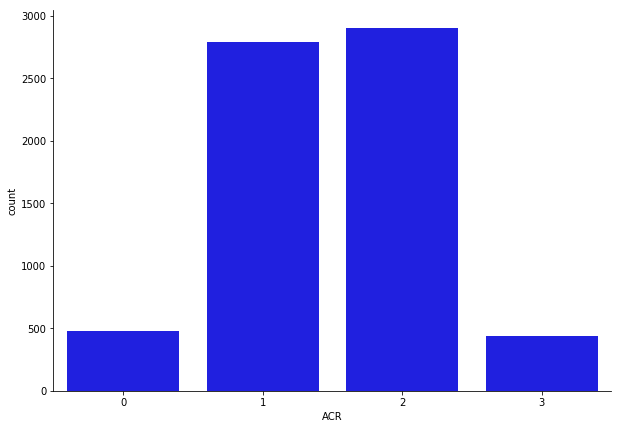

In [130]:
plt.figure(figsize=(10,7))
sns.countplot(y, color='blue')
sns.despine()

## Balanceando las clases

In [131]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(return_indices=True)
X, y, rus_index = rus.fit_sample(X, y)

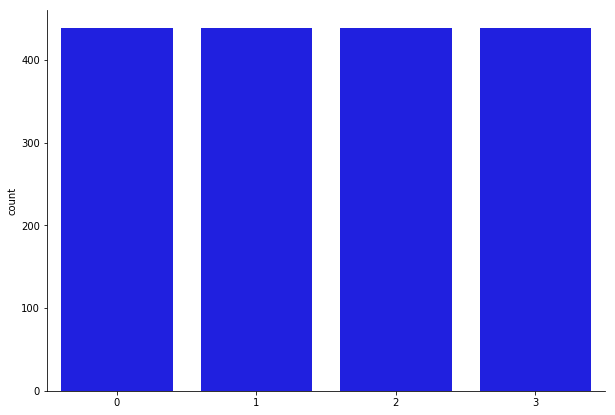

In [132]:
plt.figure(figsize=(10,7))
sns.countplot(y, color='blue')
sns.despine()

# Clustering

https://scikit-learn.org/stable/auto_examples/cluster/plot_cluster_comparison.html

In [133]:
#bandwidth = cluster.estimate_bandwidth(X, quantile=params['quantile'])

connectivity = kneighbors_graph(X, 
                                n_neighbors = 20, 
                                mode = 'connectivity', 
                                metric = 'minkowski', 
                                p = 2, 
                                metric_params = None, 
                                include_self = False, 
                                n_jobs = 8)

connectivity = 0.5 * (connectivity + connectivity.T)

In [139]:
ward = cluster.AgglomerativeClustering(n_clusters = 4, 
                                       affinity = 'euclidean', 
                                       memory = None, 
                                       connectivity = connectivity, 
                                       compute_full_tree = 'auto', 
                                       linkage = 'ward', 
                                       pooling_func = 'deprecated', 
                                       distance_threshold = None)


gmm = mixture.GaussianMixture(n_components = 4,
                              covariance_type='full', 
                              tol=0.001, 
                              reg_covar=1e-06, 
                              max_iter=100, 
                              n_init=1, 
                              init_params='kmeans', 
                              weights_init=None, 
                              means_init=None, 
                              precisions_init=None, 
                              random_state=42,
                              warm_start=False, 
                              verbose=0, 
                              verbose_interval=10)


kmeans = cluster.KMeans(n_clusters = 4, 
                        init = 'k-means++', 
                        n_init = 10, 
                        max_iter = 300, 
                        tol = 0.0001, 
                        precompute_distances = 'auto', 
                        verbose = 0, 
                        random_state = 42, 
                        copy_x = True, 
                        n_jobs = 8, 
                        algorithm = 'auto')


birch = cluster.Birch(threshold=0.5,
                      branching_factor=50,
                      n_clusters=4,
                      compute_labels=True,
                      copy=True)

model = gmm

In [140]:
clustering = model.fit(X)

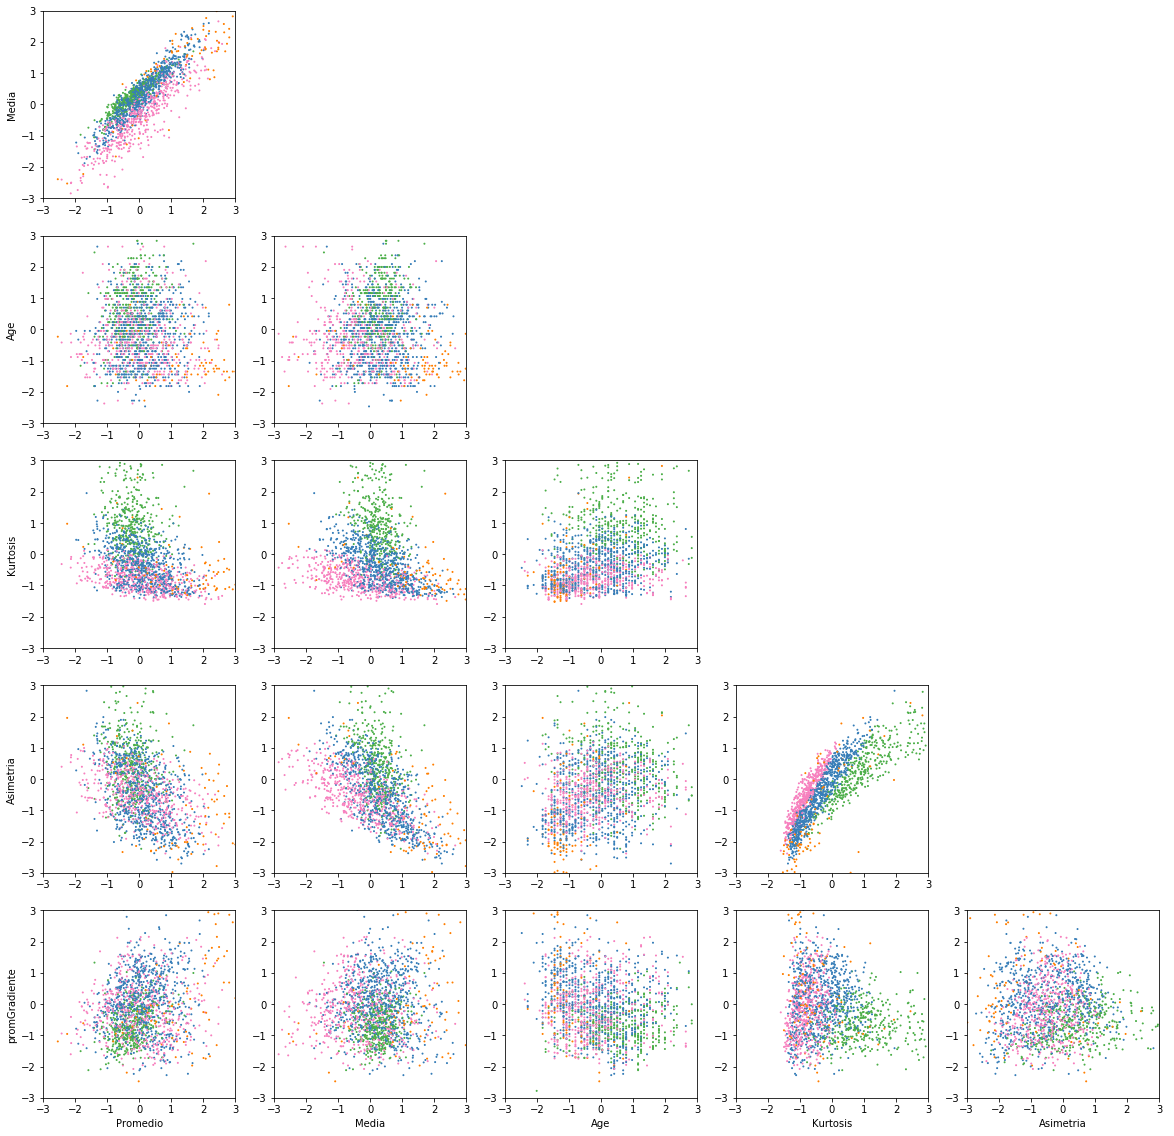

In [141]:
#y_pred = clustering.labels_.astype(np.int)
y_pred = model.predict(X)

colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a',
                                     '#f781bf', '#a65628', '#984ea3',
                                     '#999999', '#e41a1c', '#dede00']),
                                      int(max(y_pred) + 1))))
        
# add black color for outliers (if any)
colors = np.append(colors, ["#000000"])

n_vars = X.shape[1]

fig, axs = plt.subplots(nrows=n_vars-1, ncols=n_vars-1, figsize=(20, 20))

for ax in axs.flat:
    ax.set_axis_off()


for i in range(n_vars):
    for j in range(i+1,n_vars):
        ax.set_axis_on()
        
        ax = axs[j-1,i]
        ax.scatter(X[:,i], X[:,j], s=1, color=colors[y_pred])

        if j == n_vars-1:
            ax.set_xlabel(features[i])
            
        if i == 0:
            ax.set_ylabel(features[j])
        
        ax.set_xlim(-3.0, 3.0)
        ax.set_ylim(-3.0, 3.0)

In [142]:
print("Purity: ", purity_score(y, y_pred))

M = metrics.cluster.contingency_matrix(y, y_pred)
print(M)

Purity:  0.4514840182648402
[[142  13 265  18]
 [230  14 146  48]
 [184  17  11 226]
 [176  70   2 190]]


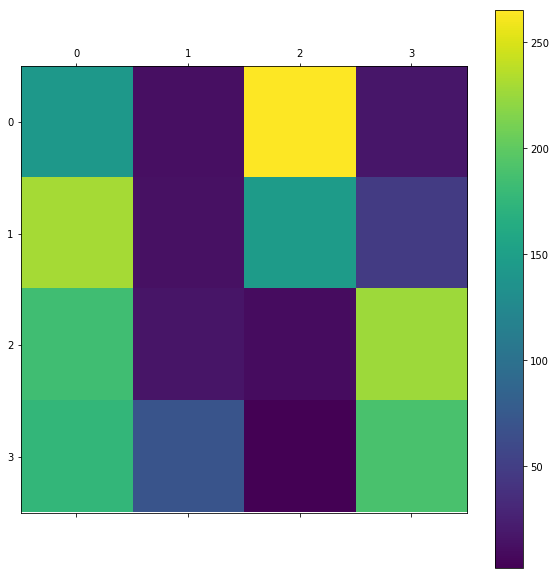

In [143]:
plt.matshow(M)
plt.colorbar()

AttributeError: 'GaussianMixture' object has no attribute 'inertia_'

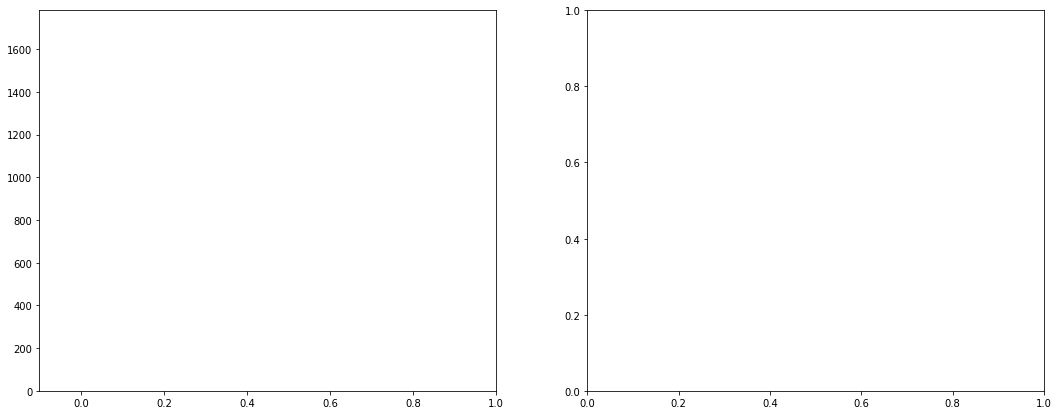

In [103]:
range_n_clusters = [2,3,4,5,6,7,8,9,10,11,12]
sse = {}
for n_clusters in range_n_clusters:

    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = cluster.KMeans(n_clusters = n_clusters, 
                               init = 'k-means++', 
                               n_init = 10, 
                               max_iter = 300, 
                               tol = 0.0001, 
                               precompute_distances = 'auto', 
                               verbose = 0, 
                               random_state = 42, 
                               copy_x = True, 
                               n_jobs = 8, 
                               algorithm = 'auto')
    
    
    cluster_labels = clusterer.fit_predict(X)
    sse[n_clusters] = clusterer.inertia_

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("Para n_clusters =", n_clusters,
          "El silhouette_score promedio es :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("Visualizacion de los datos.")
    ax1.set_xlabel("espacio de la primera caracteristica")
    ax1.set_ylabel("espacio de la segunda caracteristica")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])


    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("Visualizacion de los datos.")
    ax2.set_xlabel("espacio de la primera caracteristica")
    ax2.set_ylabel("espacio de la segunda caracteristica")

    plt.suptitle(("Analisis de silueta para Kmedias "
                  "con n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')
    #plt.savefig("kmeans_%d" % n_clusters, dpi=300)

plt.show()

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(18, 7)
plt.suptitle(("Metodo del codo para kmedias "), fontsize=14, fontweight='bold')
ax1.plot(list(sse.keys()), list(sse.values()))
ax1.set_xlabel("Numero of cluster")
ax1.set_ylabel("Inercia")

clusterer = cluster.KMeans(n_clusters=2, random_state=42)
cluster_labels = clusterer.fit_predict(X)
    
colors = cm.nipy_spectral(cluster_labels.astype(float) / 4)
ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,c=colors, edgecolor='k')

# Labeling the clusters
centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
ax2.scatter(centers[:, 0], centers[:, 1], marker='o',c="white", alpha=1, s=200, edgecolor='k')

for i, c in enumerate(centers):
    ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,s=50, edgecolor='k')

ax2.set_title("Visualizacion de los datos.")
ax2.set_xlabel("espacio de la primera caracteristica")
ax2.set_ylabel("espacio de la segunda caracteristica")

#plt.savefig("kmeans_elbow", dpi=300)
plt.show()

# Comparación tomando diferentes grupos de características

In [104]:
purity = {}

In [108]:
kmeans = cluster.KMeans(n_clusters = 4, 
                        init = 'k-means++', 
                        n_init = 10, 
                        max_iter = 300, 
                        tol = 0.0001, 
                        precompute_distances = 'auto', 
                        verbose = 0, 
                        random_state = 42, 
                        copy_x = True, 
                        n_jobs = 8, 
                        algorithm = 'auto')

gmm = mixture.GaussianMixture(n_components = 4,
                              covariance_type='full', 
                              tol=0.001, 
                              reg_covar=1e-06, 
                              max_iter=100, 
                              n_init=1, 
                              init_params='kmeans', 
                              weights_init=None, 
                              means_init=None, 
                              precisions_init=None, 
                              random_state=42,
                              warm_start=False, 
                              verbose=0, 
                              verbose_interval=10)

model = gmm

## DF

In [105]:
X = data[DF_features].iloc[rus_index]
y = data[y_feature].iloc[rus_index]

In [107]:
X = StandardScaler().fit_transform(X)

In [109]:
model.fit(X)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
                means_init=None, n_components=4, n_init=1, precisions_init=None,
                random_state=42, reg_covar=1e-06, tol=0.001, verbose=0,
                verbose_interval=10, warm_start=False, weights_init=None)

Purity:  0.553082191780822
[[ 23  79  17 319]
 [163  76  29 170]
 [225 157  37  19]
 [ 12 306 119   1]]
[438 438 438 438]


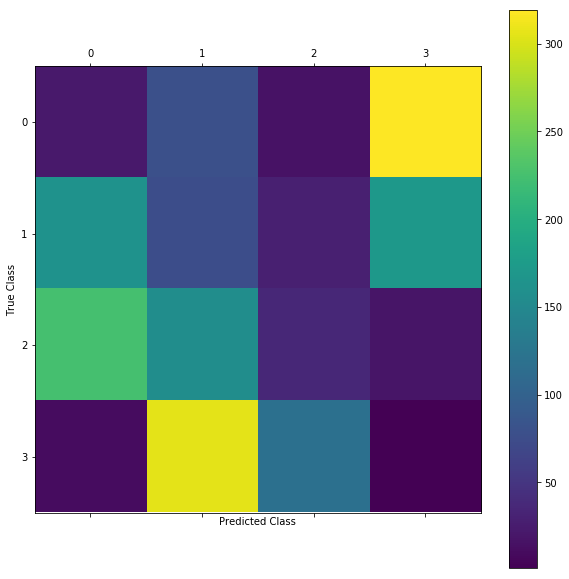

In [110]:
y_pred = model.predict(X)
purity["DF"] = purity_score(y, y_pred)
print("Purity: ", purity["DF"])
M = metrics.cluster.contingency_matrix(y, y_pred)
print(M)
print(np.sum(M,axis=1))
plt.matshow(M)
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.colorbar()

## DFb

In [111]:
X = data[DFb_features].iloc[rus_index]
y = data[y_feature].iloc[rus_index]

In [113]:
X = StandardScaler().fit_transform(X)

In [114]:
model.fit(X)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
                means_init=None, n_components=4, n_init=1, precisions_init=None,
                random_state=42, reg_covar=1e-06, tol=0.001, verbose=0,
                verbose_interval=10, warm_start=False, weights_init=None)

Purity:  0.4434931506849315
[[ 42 334   2  60]
 [100 250  15  73]
 [247  81  17  93]
 [270  27  80  61]]
[438 438 438 438]


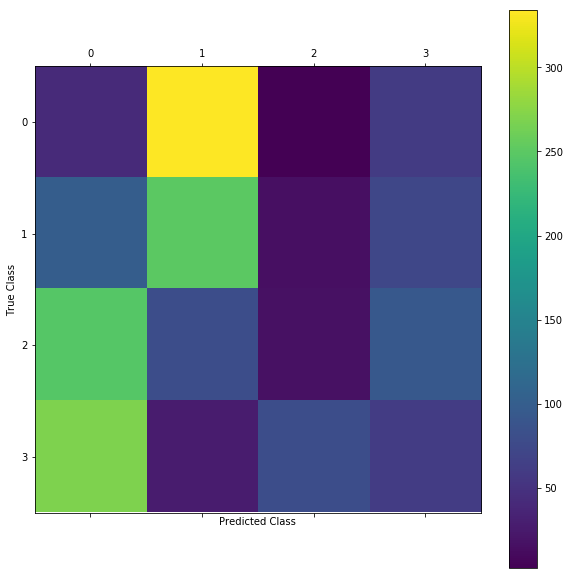

In [115]:
y_pred = model.predict(X)
purity["DFb"] = purity_score(y, y_pred)
print("Purity: ", purity["DFb"])
M = metrics.cluster.contingency_matrix(y, y_pred)
print(M)
print(np.sum(M,axis=1))
plt.matshow(M)
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.colorbar()

## Haralick

In [116]:
X = data[Haralick_features].iloc[rus_index]
y = data[y_feature].iloc[rus_index]

In [118]:
X = StandardScaler().fit_transform(X)

In [119]:
model.fit(X)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
                means_init=None, n_components=4, n_init=1, precisions_init=None,
                random_state=42, reg_covar=1e-06, tol=0.001, verbose=0,
                verbose_interval=10, warm_start=False, weights_init=None)

Purity:  0.4486301369863014
[[ 12 314 111   1]
 [ 27 205 195  11]
 [ 87  41 277  33]
 [103   2 241  92]]
[438 438 438 438]


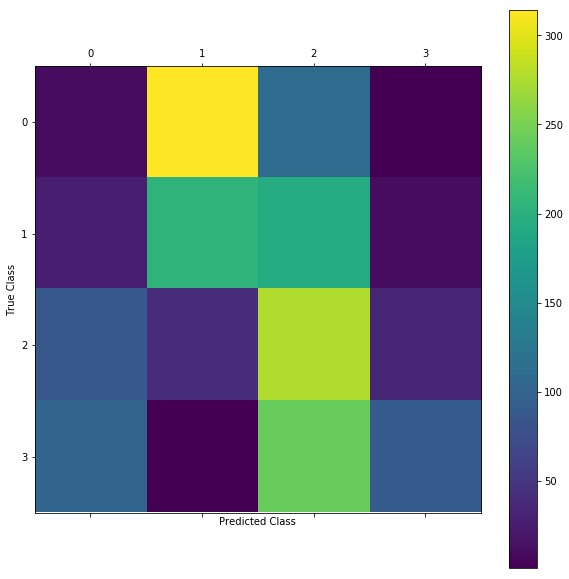

In [120]:
y_pred = model.predict(X)
purity["Haralick"] = purity_score(y, y_pred)
print("Purity: ", purity["Haralick"])
M = metrics.cluster.contingency_matrix(y, y_pred)
print(M)
print(np.sum(M,axis=1))
plt.matshow(M)
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.colorbar()

## Otras

In [121]:
X = data[Others_features].iloc[rus_index]
y = data[y_feature].iloc[rus_index]

In [123]:
X = StandardScaler().fit_transform(X)

In [124]:
model.fit(X)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
                means_init=None, n_components=4, n_init=1, precisions_init=None,
                random_state=42, reg_covar=1e-06, tol=0.001, verbose=0,
                verbose_interval=10, warm_start=False, weights_init=None)

Purity:  0.4765981735159817
[[  8  80 335  15]
 [ 41  97 182 118]
 [ 55  77  18 288]
 [106 106   0 226]]
[438 438 438 438]


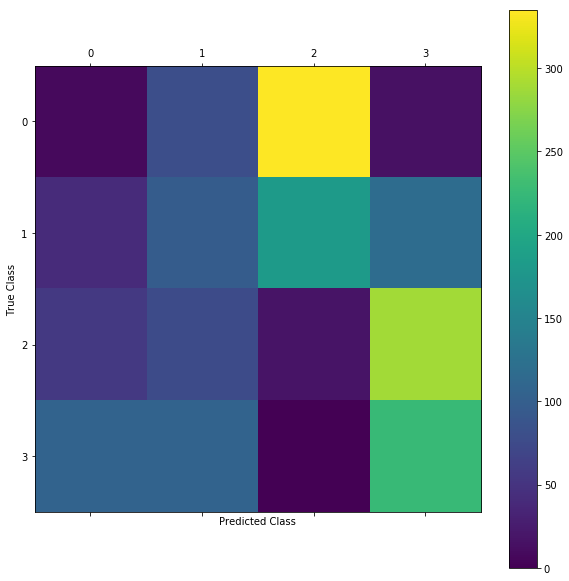

In [125]:
y_pred = model.predict(X)
purity["Others"] = purity_score(y, y_pred)
print("Purity: ", purity["Others"])
M = metrics.cluster.contingency_matrix(y, y_pred)
print(M)
print(np.sum(M,axis=1))
plt.matshow(M)
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.colorbar()

## Comparando el purity con la diferentes grupos de características

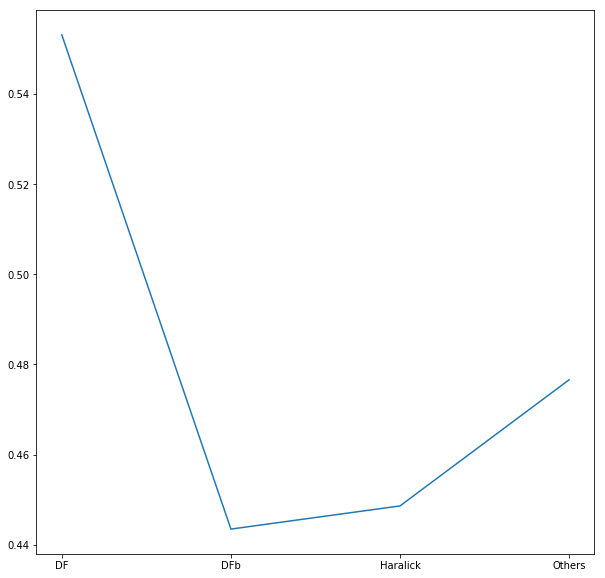

In [126]:
plt.plot(list(purity.keys()), list(purity.values()))